<a href="https://colab.research.google.com/github/N47IN/Object-Detection-and-Image-Processing/blob/main/MeshRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@ Credit to [Meher Shashwat Nigam](https://www.linkedin.com/in/mehershashwatnigam/) ( Github: [ShashwatNigam99](https://github.com/ShashwatNigam99), Email: meher.shashwat@students.iiit.ac.in)

and [Alberto Tono](https://www.linkedin.com/in/albertotono3/) (Email: alberto.tono@cd.institute)

# Requirements and Setup
It will take a while to install all the dependencies and expect around 20min to run this demo on this Google Colab

In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
%env FORCE_CUDA=1
!pip install -U torch==2.1.0 torchvision==0.16.0
!pip install pyyaml==5.1 pycocotools>=2.0.1
!pip install -U fvcore==0.1.3.post20210317
!pip install -U --force-reinstall iopath==0.1.6
!pip install 'git+https://github.com/facebookresearch/detectron2.git@4b539e41f4b19570bc6b722fa0f516f927cdae02'
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

env: FORCE_CUDA=1
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.4 MB/s eta

## Imports and checking installation parameters(python 3.6.9, cuda 10.1)

In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available(),torch.cuda.device_count())
!gcc --version
!python --version
!nvcc --version
!nvidia-smi
!python -m detectron2.utils.collect_env

2.1.0+cu121 True 1
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Jan 28 10:32:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                              

## Installing meshrcnn
It will create a folder structure on your left in which you can navigate


In [5]:
!git clone https://github.com/facebookresearch/meshrcnn.git
!cd meshrcnn && pip install -e .

fatal: destination path 'meshrcnn' already exists and is not an empty directory.
Obtaining file:///content/meshrcnn
  Preparing metadata (setup.py) ... done
  Running setup.py develop for meshrcnn


# Loading Pix3D Dataset
Also this import will take a while since it is loading the entire dataset 3.5GB


In [6]:
# pix3d data
!./meshrcnn/datasets/pix3d/download_pix3d.sh

--2024-01-28 10:33:14--  http://pix3d.csail.mit.edu/data/pix3d.zip
Resolving pix3d.csail.mit.edu (pix3d.csail.mit.edu)... 128.52.131.62
Connecting to pix3d.csail.mit.edu (pix3d.csail.mit.edu)|128.52.131.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783261880 (3.5G) [application/zip]
Saving to: ‘pix3d.zip’

pix3d.zip           100%[===================>]   3.52G  32.0MB/s    in 1m 54s  

2024-01-28 10:35:08 (31.7 MB/s) - ‘pix3d.zip’ saved [3783261880/3783261880]

--2024-01-28 10:35:58--  https://dl.fbaipublicfiles.com/meshrcnn/pix3d/pix3d_s1_train.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781155 (4.6M) [text/plain]
Saving to: ‘pix3d_s1_train.json’

pix3d_s1_train.json 100%[===================>]   4.56M  --.-KB/s    in 0.09s   

2024-01-28 1

In [10]:
from google.colab import files
uploaded = files.upload()  # import a sofa from your computer and name it test.jpg

Saving test.jpg to test.jpg


## Demo (Inference)

In [11]:
# Running Demo on random image of the pix3d dataset, change according to your need (change 'test.jpg' to your file name)
# Be sure to upload the file on the correct folder

!python ./meshrcnn/demo/demo.py --config-file ./meshrcnn/configs/pix3d/meshrcnn_R50_FPN.yaml \
--input /content/test.jpg --output output_demo --onlyhighest MODEL.WEIGHTS meshrcnn://meshrcnn_R50.pth

[01/28 10:37:58 demo]: Arguments: Namespace(config_file='./meshrcnn/configs/pix3d/meshrcnn_R50_FPN.yaml', input='/content/test.jpg', output='output_demo', focal_length=20.0, onlyhighest=True, opts=['MODEL.WEIGHTS', 'meshrcnn://meshrcnn_R50.pth'])
meshrcnn_R50.pth: 487MB [00:06, 73.8MB/s]              
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[01/28 10:38:10 demo]: Predictions saved in output_demo/test


# Visualize the Picture Uploaded and the Segmentation Mask

In [12]:
filename = 'test.jpg' #check the name is the same as the file you uploaded
maskname = '0_mask_sofa_1.000.png' # Make sure to change the file name with the appropriate mask change 'test/0_mask_sofa_1.000.png'

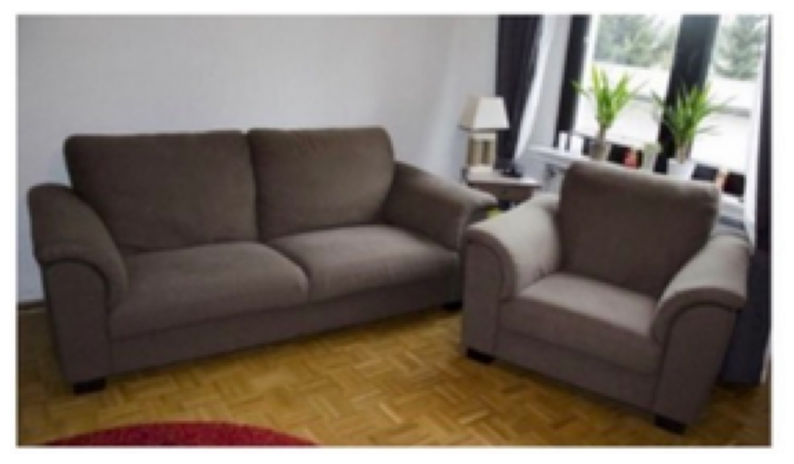

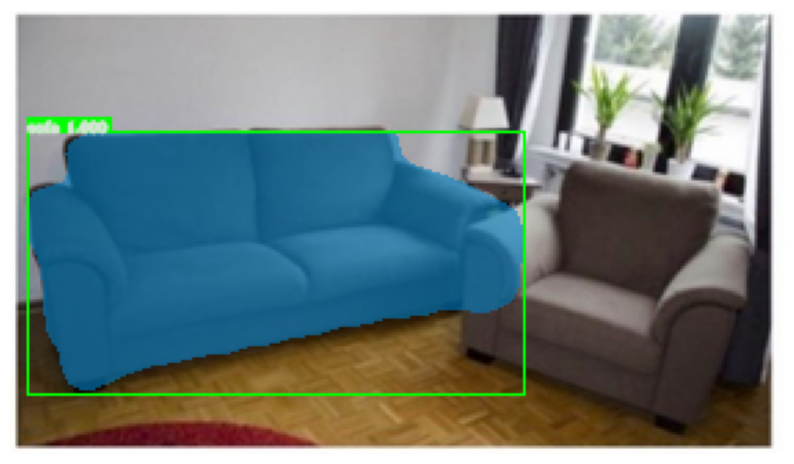

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

img = plt.imread("/content/" + filename)
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
img = plt.imread("/content/output_demo/test/" + maskname)
plt.imshow(img)
plt.axis('off')
plt.show()

# Download the .obj file

In [15]:
name = 'sofa' # change file name accordingly

In [16]:
from google.colab import files
files.download('/content/output_demo/test/0_mesh_'+ name + '_1.000.obj')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>